# 2.04 Figure 4

---

Author: Riley X. Brady

Date: 11/19/20

This plots the distribution of biogeochemical tracers at their statistical origin relative to their 1000 m crossing. See notebook `1.03` for the calculation of tracers at their memory time origin and `1.04` for finding their ambient mixed layer temperatures.

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import proplot as plot
import gsw
import PyCO2SYS as pyco2

In [2]:
print(f"numpy: {np.__version__}")
print(f"xarray: {xr.__version__}")
print(f"proplot: {plot.__version__}")
print(f"gsw: {gsw.__version__}")
print(f"pyCO2: {pyco2.__version__}")

numpy: 1.19.4
xarray: 0.16.1
proplot: 0.6.4
gsw: 3.4.0
pyCO2: 1.6.0


In [3]:
REGIONS = ["drake", "crozet", "kerguelan", "campbell"]

First, we start with dissolved inorganic carbon. Our model outputs DIC with units of mmol m$^{-3}$. Here, we use *in situ* density to convert to $\mu$mol kg$^{-1}$ to account for density effects.

In [4]:
dicdata = []
for region_name in REGIONS:
    region = xr.open_dataset(f"../data/postproc/{region_name}.1000m.tracer.origin.nc")
    # Load into memory as a numpy array.
    dic = region.DIC.values
    S = region.S.values
    T = region.T.values
    z = region.z.values * -1

    # Convert to kg m-3
    rho = gsw.density.rho(S, T, z)
    dic = dic[~np.isnan(dic)]
    rho = rho[~np.isnan(rho)]
    conversion = 1000 * (1 / rho)
    dicdata.append(list(dic * conversion))

Next, we calculate potential density reference to the surface ($\sigma_{0}$). We use this as a simple marker for water mass types.

In [5]:
sigmadata = []
for region_name in REGIONS:
    data = xr.open_dataset(f"../data/postproc/{region_name}.1000m.tracer.origin.nc")
    T = data.T.values
    T = T[~np.isnan(T)]
    S = data.S.values
    S = S[~np.isnan(S)]
    sigma0 = gsw.sigma0(S, T)
    sigmadata.append(list(sigma0))

Lastly, we calculate the potential pCO$_{2}$. This is the pCO$_{2}$ the particle would have if it were warmed or cooled to the ambient temperature it eventually experiences once it upwells into the mixed layer after its last 1000 m crossing. This assumes that there are no modifications to the carbon content of the particle due to air-sea gas exchange, biological processes, mixing, etc. It's a way to relate the pCO$_{2}$ at any point in its trajectory to the outgasing or uptake potential it would have upon reaching the surface ocean.

This works, since:

 F$_{\mathrm{CO}_{2}}$ = k $\cdot$ S $\cdot$ (pCO$_{2}^{O}$ - pCO$_{2}^{A}$)

In other words,  F$_{\mathrm{CO}_{2}}$ $\propto$ pCO$_{2}^{o}$, and it is particularly true in our simulation since we have a fixed atmospheric pCO$_{2}^{A}$ of 360 $mu$atm.

In [6]:
pco2sigmadata = []
for region_name in REGIONS:
    # Load in tracers at origin and append on the ambient temperature calculated for each
    # particle.
    data = xr.open_dataset(f"../data/postproc/{region_name}.1000m.tracer.origin.nc")
    ambient = xr.open_dataarray(
        f"../data/postproc/{region_name}.ambient.temperature.nc"
    )
    data["T_ambient"] = ambient

    # Calculate in situ density and temperature
    rho = gsw.density.rho(data.S, data.T, data.z * -1)
    t_insitu = gsw.pt_from_t(data.S, data.T, 0, data.z * -1)

    # Use in situ density to convert all units from mmol m-3 to umol kg-1
    conversion = 1000 * (1 / rho)

    # PyCO2SYS is a famous package from MATLAB. We're using the python plug-in here
    # to diagnostically calculate in situ pCO2 along the particle trajectory.
    pCO2 = pyco2.CO2SYS_nd(
        data.ALK * conversion,
        data.DIC * conversion,
        1,
        2,
        salinity=data.S,
        temperature=t_insitu,
        pressure=data.z * -1,
        total_silicate=data.SiO3 * conversion,
        total_phosphate=data.PO4 * conversion,
    )["pCO2"]

    # pCO2 if brought to the ambient temperature when the given particle upwells to
    # 200 m. We're just using a known lab-derived relationship that pCO2 varies by
    # ~4% for a degree change in temperature.f
    pCO2sigma = pCO2 * (1 + 0.0423 * (data.T_ambient - t_insitu))

    # Subtract out fixed atmospheric CO2 to get a gradient with the atmosphere.
    pCO2sigma -= 360
    pCO2sigma = pCO2sigma.dropna("nParticles").values
    pco2sigmadata.append(list(pCO2sigma))

## Visualize

I could probably modularize this and make it a lot nicer, but who cares? It's a plot for the paper and I like it. **NOTE**: I did a little bit of adjustment of text in Illustrator after the fact.

In [7]:
# supresses some numpy warnings in the plot.
import warnings

warnings.filterwarnings("ignore")

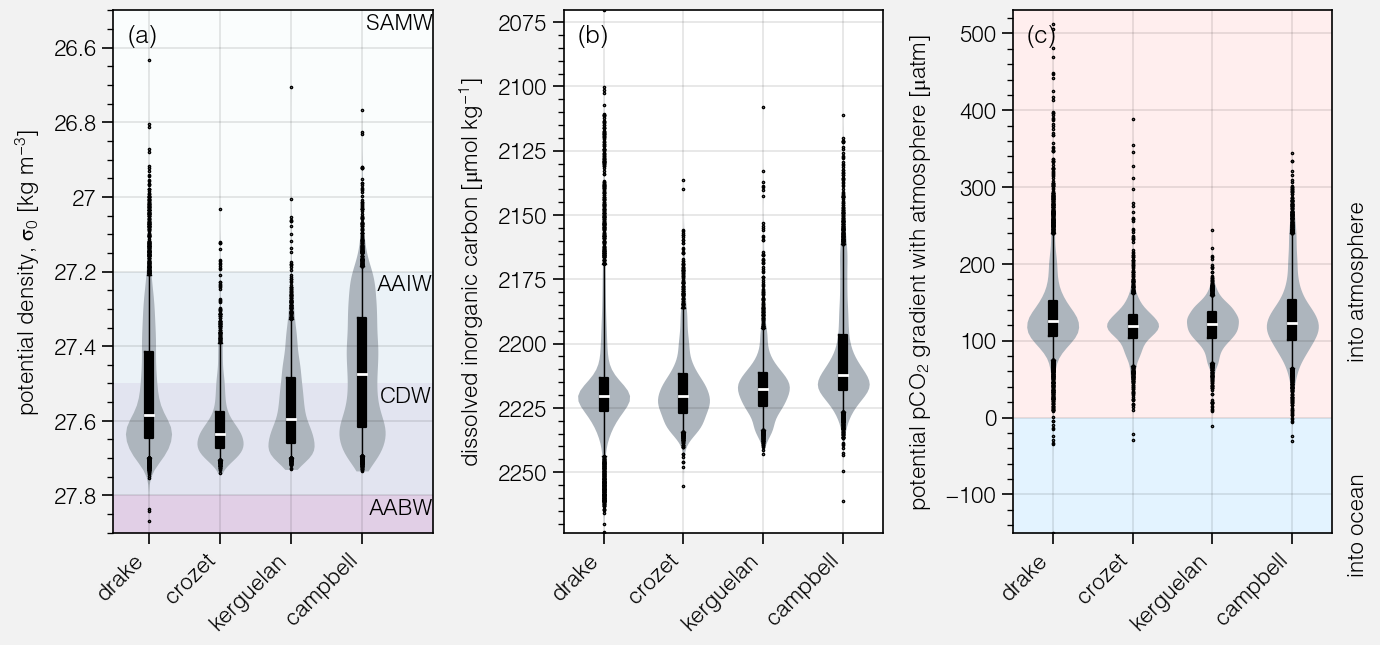

In [8]:
plot.rc["abc.border"] = False
plot.rc.fontsize = 8

f, axs = plot.subplots(
    ncols=3,
    figsize=(6.9, 6.9 * 3.5 / 7.48),
    share=0,
)

# Some global attributes for the plot
VIOLINCOLOR = "gray5"
EXTREMEMARKER = "."
EXTREMESIZE = 1.0
BOXWIDTH = 0.1
WHISKERLW = 0.5
CAPLW = 0.5

###########
# DIC PANEL
###########
axs[1].boxplot(
    dicdata,
    whis=(5, 95),
    marker=EXTREMEMARKER,
    markersize=EXTREMESIZE,
    widths=BOXWIDTH,
    fillcolor="black",
    mediancolor="white",
    boxcolor="black",
    medianlw=1,
    fillalpha=1,
    caplw=CAPLW,
    whiskerlw=WHISKERLW,
    whiskercolor="black",
    capcolor="black",
)
axs[1].violinplot(
    dicdata,
    fillcolor=VIOLINCOLOR,
    fillalpha=1,
    lw=0,
    edgecolor=VIOLINCOLOR,
    widths=0.65,
    points=100,
)
axs[1].format(
    yreverse=True,
    xticklabels=REGIONS,
    xtickminor=False,
    xrotation=45,
    ylabel="dissolved inorganic carbon [$\mu$mol kg$^{-1}$]",
)

#############
# SIGMA PANEL
#############
axs[0].boxplot(
    sigmadata,
    whis=(5, 95),
    marker=EXTREMEMARKER,
    markersize=EXTREMESIZE,
    widths=BOXWIDTH,
    fillcolor="black",
    mediancolor="white",
    boxcolor="black",
    medianlw=1,
    fillalpha=1,
    caplw=CAPLW,
    whiskerlw=WHISKERLW,
    whiskercolor="black",
    capcolor="black",
)
axs[0].violinplot(
    sigmadata,
    fillcolor=VIOLINCOLOR,
    fillalpha=1,
    lw=0,
    edgecolor=VIOLINCOLOR,
    widths=0.65,
    points=100,
)
axs[0].area([0.5, 5], 26.5, 27.2, color="#edf8fb", alpha=0.25, zorder=0)
axs[0].area([0.5, 5], 27.2, 27.5, color="#b3cde3", alpha=0.25, zorder=0)
axs[0].area([0.5, 5], 27.5, 27.8, color="#8c96c6", alpha=0.25, zorder=0)
axs[0].area([0.5, 5], 27.8, 27.9, color="#88419d", alpha=0.25, zorder=0)


axs[0].text(4.05, 26.55, "SAMW", color="k")
axs[0].text(4.2, 27.25, "AAIW", color="k")
axs[0].text(4.25, 27.55, "CDW", color="k")
axs[0].text(4.1, 27.85, "AABW", rotation=0, color="k")

axs[0].format(
    yreverse=True,
    xlim=(0.5, 5.00),
    ylim=(26.5, 27.9),
    xticklabels=REGIONS,
    xtickminor=False,
    xrotation=45,
    ylabel="potential density, $\sigma_{0}$ [kg m$^{-3}$]",
)

######################
# POTENTIAL PCO2 PANEL
######################
axs[2].boxplot(
    pco2sigmadata,
    whis=(5, 95),
    marker=EXTREMEMARKER,
    markersize=EXTREMESIZE,
    widths=BOXWIDTH,
    fillcolor="black",
    mediancolor="white",
    boxcolor="black",
    medianlw=1,
    fillalpha=1,
    caplw=CAPLW,
    whiskerlw=WHISKERLW,
    whiskercolor="black",
    capcolor="black",
)
axs[2].violinplot(
    pco2sigmadata,
    fillcolor=VIOLINCOLOR,
    fillalpha=1,
    lw=0,
    edgecolor=VIOLINCOLOR,
    widths=0.65,
    points=100,
)
axs[2].format(
    ylim=(-150, 530),
    yreverse=False,
    ylabel="potential pCO$_{2}$ gradient with atmosphere [$\mu$atm]",
    xticklabels=REGIONS,
    xtickminor=False,
    xrotation=45,
)
axs[2].area([0.5, 4.5], -300, 0, color="blue2", alpha=0.3, zorder=0)
axs[2].area([0.5, 4.5], 0, 530, color="red2", alpha=0.3, zorder=0)

axs[2].text(4.7, -200, "into ocean", rotation=90, color="k")
axs[2].text(4.7, 80, "into atmosphere", rotation=90, color="k")

axs.format(abc=True, abcstyle="(a)", abcloc="ul")